In [1]:
import os
import random
import shutil
from tqdm import tqdm
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Input, Dropout
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import PIL.Image

In [2]:
# Download the dataset
path = kagglehub.dataset_download("hearfool/vggface2")
print("Path to dataset files:", path)

100%|██████████| 2.32G/2.32G [00:21<00:00, 117MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hearfool/vggface2/versions/1


In [3]:
# Parameters
NUM_CLASSES = 40
IMAGES_PER_CLASS = 200
TRAIN_RATIO = 0.8
IMG_SIZE = (112, 112)
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE

# Define directories
original_dir = os.path.join(path, "train")
output_dir = "vggface2_split"
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [4]:
# Get all class directories
classes = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

# Select 40 classes randomly
selected_classes = random.sample(classes, NUM_CLASSES)

for cls in tqdm(selected_classes, desc="Processing classes"):
    cls_path = os.path.join(original_dir, cls)
    images = [img for img in os.listdir(cls_path) if img.endswith(".jpg")]

    # Ensure we have at least 200 images
    if len(images) < IMAGES_PER_CLASS:
        print(f"Skipping class {cls} (not enough images)")
        continue

    # Randomly select 200 images
    selected_images = random.sample(images, IMAGES_PER_CLASS)

    # Split into train and test
    split_index = int(TRAIN_RATIO * IMAGES_PER_CLASS)
    train_images = selected_images[:split_index]
    test_images = selected_images[split_index:]

    # Copy to train directory
    train_cls_dir = os.path.join(train_dir, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    for img in train_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_cls_dir, img))

    # Copy to test directory
    test_cls_dir = os.path.join(test_dir, cls)
    os.makedirs(test_cls_dir, exist_ok=True)
    for img in test_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(test_cls_dir, img))

print("Dataset split completed.")

Processing classes:  78%|███████▊  | 31/40 [00:00<00:00, 43.20it/s]

Skipping class n000253 (not enough images)


Processing classes: 100%|██████████| 40/40 [00:00<00:00, 42.83it/s]

Dataset split completed.


In [5]:
# Preprocessing function with Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

def preprocess_with_augmentation(features, labels):
    features = tf.cast(features, tf.float32) / 255.0  # Normalize
    features = data_augmentation(features)
    return features, labels

def load_images_from_directory(folder_path, img_size=(112, 112)):
    labels = []
    images = []
    class_names = sorted(os.listdir(folder_path))
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for filename in os.listdir(class_folder):
            if filename.endswith(('.tif', '.jpg', '.png')):
                img_path = os.path.join(class_folder, filename)
                try:
                    img = PIL.Image.open(img_path).convert("RGB")
                    img = img.resize(img_size)  # Resize image
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image: {img_path}")
                    continue
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names

def create_tf_datasets():
    train_ds, train_labels, train_classes = load_images_from_directory(train_dir, IMG_SIZE)
    test_ds, test_labels, _ = load_images_from_directory(test_dir, IMG_SIZE)

    train_tensor_ds = tf.data.Dataset.from_tensor_slices((train_ds, train_labels))
    train_tensor_ds = train_tensor_ds.map(preprocess_with_augmentation).shuffle(5000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    test_tensor_ds = tf.data.Dataset.from_tensor_slices((test_ds, test_labels))
    test_tensor_ds = test_tensor_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    return train_tensor_ds, test_tensor_ds, train_classes

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Generate TensorFlow datasets
train_ds, test_ds, class_names = create_tf_datasets()
num_classes = len(class_names)

# Build and compile the model
input_shape = IMG_SIZE + (3,)
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pre-trained Xception model without the top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
# Freeze the layers in the base model
base_model.trainable = False
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks for Early Stopping and Model Checkpoint
checkpoint_path = "/content/drive/My Drive/Deep Learning/final/checkpoint.keras"
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Save the final model
model.save("/content/drive/My Drive/Deep Learning/final/model1.h5")
print("Model training completed and saved.")

Epoch 1/3
1556/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1812 - loss: 3.0143
Epoch 1: val_loss improved from inf to 2.22688, saving model to /content/drive/My Drive/Deep Learning/final/checkpoint.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.1814 - loss: 3.0133 - val_accuracy: 0.3327 - val_loss: 2.2269
Epoch 2/3
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3353 - loss: 2.2266
Epoch 2: val_loss improved from 2.22688 to 2.10856, saving model to /content/drive/My Drive/Deep Learning/final/checkpoint.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.3353 - loss: 2.2266 - val_accuracy: 0.3615 - val_loss: 2.1086
Epoch 3/3
1555/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3861 - loss: 2.0415
Epoch 3: val_loss improved from 2.10856 to 2.09987, saving model to /content/drive/My Drive/Deep Learning/final/checkpoint.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 78s 16ms/step - accuracy: 0.3861 - loss: 2.0416 - val_accuracy: 0.3795 - val_los

Model training completed and saved.


In [11]:
# Additional training
new_history1 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=6,
    initial_epoch=3,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model2.h5")
print("Model training completed and saved.")

Epoch 4/6
1554/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4853 - loss: 1.7125
Epoch 4: val_loss did not improve from 1.94393
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.4853 - loss: 1.7126 - val_accuracy: 0.4353 - val_loss: 2.0074
Epoch 5/6
1555/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5015 - loss: 1.6437
Epoch 5: val_loss improved from 1.94393 to 1.92835, saving model to /content/drive/My Drive/Deep Learning/final/checkpoint.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.5015 - loss: 1.6439 - val_accuracy: 0.4365 - val_loss: 1.9283
Epoch 6/6
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5147 - loss: 1.6055
Epoch 6: val_loss did not improve from 1.92835
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.5147 - loss: 1.6056 - val_accuracy: 0.4372 - val_loss: 2.0345


Model training completed and saved.


In [18]:
# Additional training
new_history2 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=9,
    initial_epoch=6,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 7/9
1557/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5296 - loss: 1.5623
Epoch 7: val_loss improved from 1.92835 to 1.90993, saving model to /content/drive/My Drive/Deep Learning/final/checkpoint.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 57s 20ms/step - accuracy: 0.5295 - loss: 1.5624 - val_accuracy: 0.4532 - val_loss: 1.9099
Epoch 8/9
1556/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5185 - loss: 1.5613
Epoch 8: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - accuracy: 0.5185 - loss: 1.5615 - val_accuracy: 0.4513 - val_loss: 1.9667
Epoch 9/9
1556/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5424 - loss: 1.5212
Epoch 9: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.5424 - loss: 1.5214 - val_accuracy: 0.4513 - val_loss: 1.9884


Model training completed and saved.


In [22]:
# Additional training
new_history3 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=12,
    initial_epoch=9,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 10/12
1556/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5536 - loss: 1.4918
Epoch 10: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 59s 17ms/step - accuracy: 0.5535 - loss: 1.4919 - val_accuracy: 0.4622 - val_loss: 2.0229
Epoch 11/12
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5569 - loss: 1.4772
Epoch 11: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 74s 18ms/step - accuracy: 0.5569 - loss: 1.4772 - val_accuracy: 0.4314 - val_loss: 2.1273
Epoch 12/12
1557/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5564 - loss: 1.4643
Epoch 12: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.5564 - loss: 1.4644 - val_accuracy: 0.4417 - val_loss: 2.0972


Model training completed and saved.


In [25]:
# Additional training
new_history4 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=16,
    initial_epoch=12,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 13/16
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5762 - loss: 1.4214
Epoch 13: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 59s 22ms/step - accuracy: 0.5762 - loss: 1.4214 - val_accuracy: 0.4692 - val_loss: 2.0422
Epoch 14/16
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5786 - loss: 1.4181
Epoch 14: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - accuracy: 0.5786 - loss: 1.4181 - val_accuracy: 0.4365 - val_loss: 2.0859
Epoch 15/16
1555/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5855 - loss: 1.4182
Epoch 15: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - accuracy: 0.5855 - loss: 1.4183 - val_accuracy: 0.4410 - val_loss: 2.0455
Epoch 16/16
1556/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5897 - loss: 1.3776
Epoch 16: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step - accuracy: 0.5897 - loss: 1.3777 - val_

Model training completed and saved.


In [28]:
# Additional training
new_history5 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    initial_epoch=16,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 17/20
1557/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5898 - loss: 1.3576
Epoch 17: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 56s 18ms/step - accuracy: 0.5897 - loss: 1.3577 - val_accuracy: 0.4545 - val_loss: 2.1274
Epoch 18/20
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5872 - loss: 1.3801
Epoch 18: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.5872 - loss: 1.3801 - val_accuracy: 0.4776 - val_loss: 2.0602
Epoch 19/20
1556/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5974 - loss: 1.3466
Epoch 19: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.5974 - loss: 1.3467 - val_accuracy: 0.4712 - val_loss: 2.0751
Epoch 20/20
1555/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6082 - loss: 1.2492
Epoch 20: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.6082 - loss: 1.2495 - val_

Model training completed and saved.


In [31]:
# Additional training
new_history6 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=25,
    initial_epoch=20,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 21/25
1557/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6134 - loss: 1.2878
Epoch 21: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 57s 16ms/step - accuracy: 0.6134 - loss: 1.2879 - val_accuracy: 0.4603 - val_loss: 2.2403
Epoch 22/25
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6249 - loss: 1.2672
Epoch 22: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.6249 - loss: 1.2673 - val_accuracy: 0.4724 - val_loss: 2.2230
Epoch 23/25
1556/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6224 - loss: 1.2594
Epoch 23: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - accuracy: 0.6223 - loss: 1.2595 - val_accuracy: 0.4667 - val_loss: 2.1960
Epoch 24/25
1556/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6284 - loss: 1.2073
Epoch 24: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.6284 - loss: 1.2075 - val_

Model training completed and saved.


In [34]:
# Additional training
new_history7 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
    initial_epoch=25,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 26/30
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6261 - loss: 1.2457
Epoch 26: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 56s 16ms/step - accuracy: 0.6261 - loss: 1.2457 - val_accuracy: 0.4654 - val_loss: 2.4015
Epoch 27/30
1555/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6257 - loss: 1.2392
Epoch 27: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step - accuracy: 0.6257 - loss: 1.2394 - val_accuracy: 0.4545 - val_loss: 2.3384
Epoch 28/30
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6452 - loss: 1.2157
Epoch 28: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 80s 17ms/step - accuracy: 0.6451 - loss: 1.2158 - val_accuracy: 0.4583 - val_loss: 2.2973
Epoch 29/30
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6544 - loss: 1.1500
Epoch 29: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 83s 17ms/step - accuracy: 0.6544 - loss: 1.1501 - val_

Model training completed and saved.


In [37]:
for layer in base_model.layers:
    layer.trainable = True

In [38]:
# Additional training
new_history8 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=33,
    initial_epoch=30,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 31/33
1556/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6435 - loss: 1.1928
Epoch 31: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.6435 - loss: 1.1929 - val_accuracy: 0.4660 - val_loss: 2.3309
Epoch 32/33
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6520 - loss: 1.1630
Epoch 32: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - accuracy: 0.6520 - loss: 1.1631 - val_accuracy: 0.4712 - val_loss: 2.2695
Epoch 33/33
1557/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6490 - loss: 1.1926
Epoch 33: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 75s 16ms/step - accuracy: 0.6490 - loss: 1.1927 - val_accuracy: 0.4699 - val_loss: 2.3262


Model training completed and saved.


In [41]:
# Additional training
new_history9 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=37,
    initial_epoch=33,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 34/37
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6561 - loss: 1.1724
Epoch 34: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.6561 - loss: 1.1724 - val_accuracy: 0.4686 - val_loss: 2.4655
Epoch 35/37
1556/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6523 - loss: 1.1677
Epoch 35: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.6523 - loss: 1.1679 - val_accuracy: 0.4712 - val_loss: 2.3355
Epoch 36/37
1555/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6529 - loss: 1.1523
Epoch 36: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.6528 - loss: 1.1524 - val_accuracy: 0.4718 - val_loss: 2.4157
Epoch 37/37
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6478 - loss: 1.1788
Epoch 37: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 52s 17ms/step - accuracy: 0.6478 - loss: 1.1788 - val_

Model training completed and saved.


In [44]:
# Additional training
new_history10 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=40,
    initial_epoch=37,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 38/40
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6607 - loss: 1.1318
Epoch 38: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 56s 17ms/step - accuracy: 0.6607 - loss: 1.1319 - val_accuracy: 0.4705 - val_loss: 2.4225
Epoch 39/40
1557/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6681 - loss: 1.1174
Epoch 39: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 73s 16ms/step - accuracy: 0.6680 - loss: 1.1175 - val_accuracy: 0.4500 - val_loss: 2.4045
Epoch 40/40
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6776 - loss: 1.0921
Epoch 40: val_loss did not improve from 1.90993
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - accuracy: 0.6776 - loss: 1.0922 - val_accuracy: 0.4506 - val_loss: 2.6297


Model training completed and saved.


In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model predictions on the test dataset
y_true = []
y_pred = []
y_pred_probs = []

# Iterate over the test dataset to collect predictions and true labels
for features, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(features))
    y_pred.extend(np.argmax(model.predict(features), axis=-1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

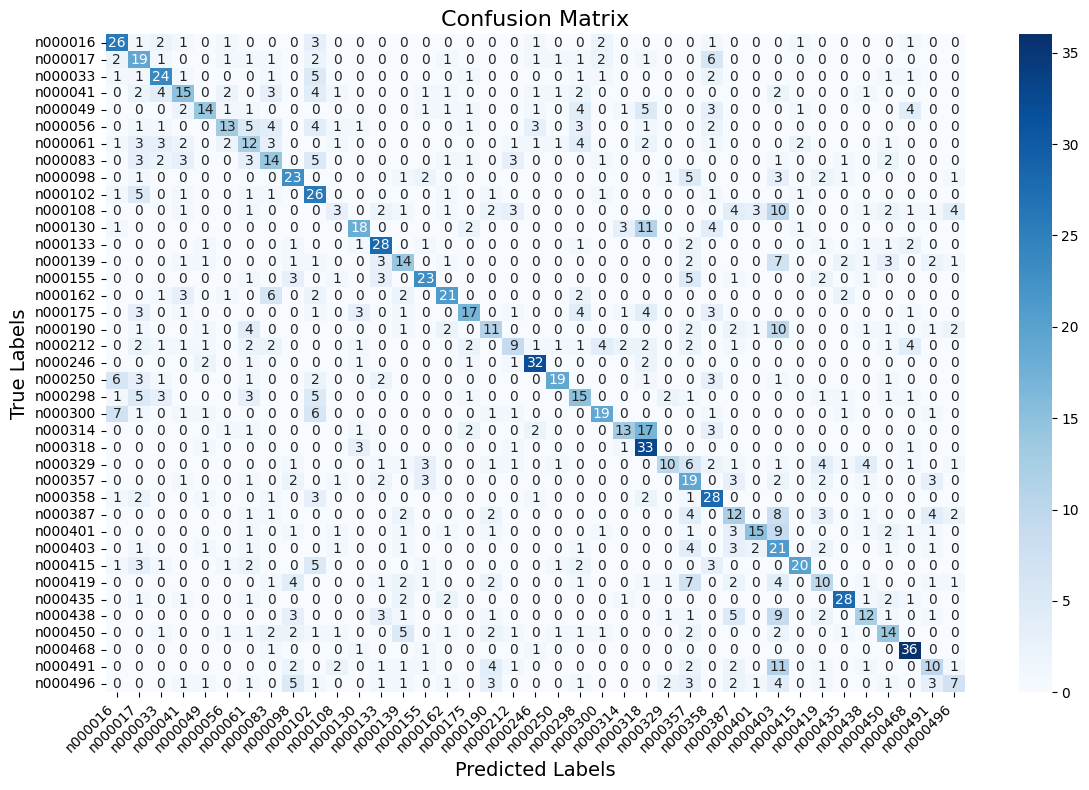

In [46]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


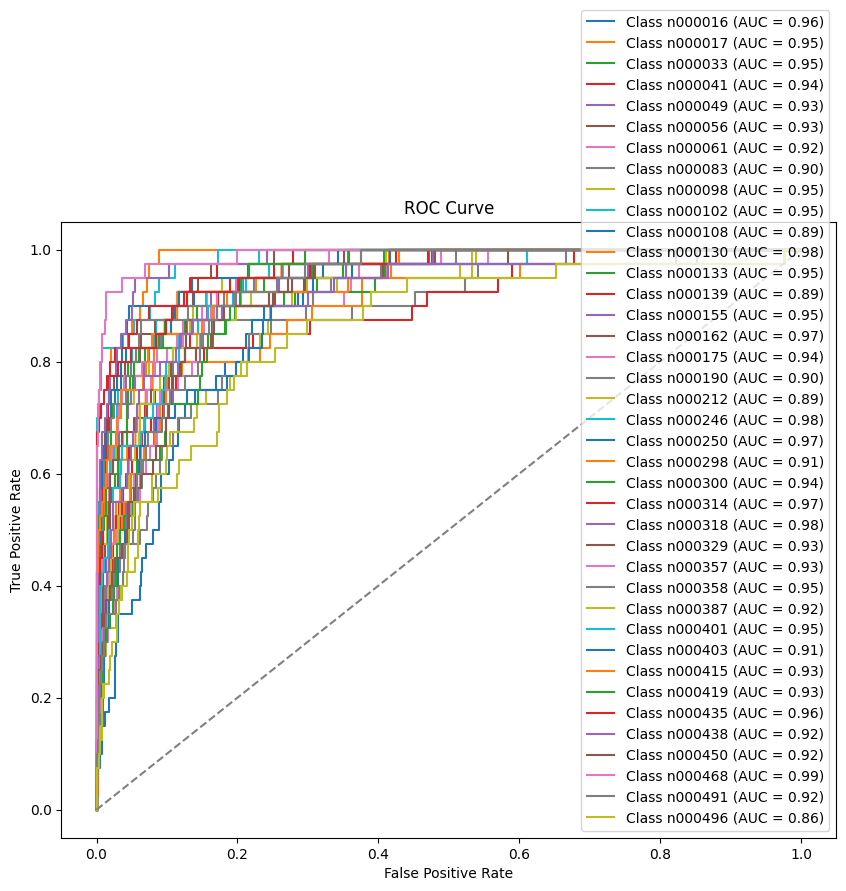

Macro-Average ROC AUC: 0.94


In [47]:
# Compute ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Add random chance line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Compute overall macro-average ROC AUC
macro_roc_auc = roc_auc_score(y_true, y_pred_probs, multi_class="ovr", average="macro")
print(f"Macro-Average ROC AUC: {macro_roc_auc:.2f}")

In [48]:
# Merge histories from all training phases
def combine_histories(*histories):
    combined_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for hist in histories:
        for key in combined_history.keys():
            combined_history[key].extend(hist.history[key])
    return combined_history

# Combine histories
full_history = combine_histories(history, new_history1, new_history2, new_history3, new_history4 , new_history6 , new_history6 , new_history6, new_history6 , new_history6,new_history7,new_history8,new_history9,new_history10)

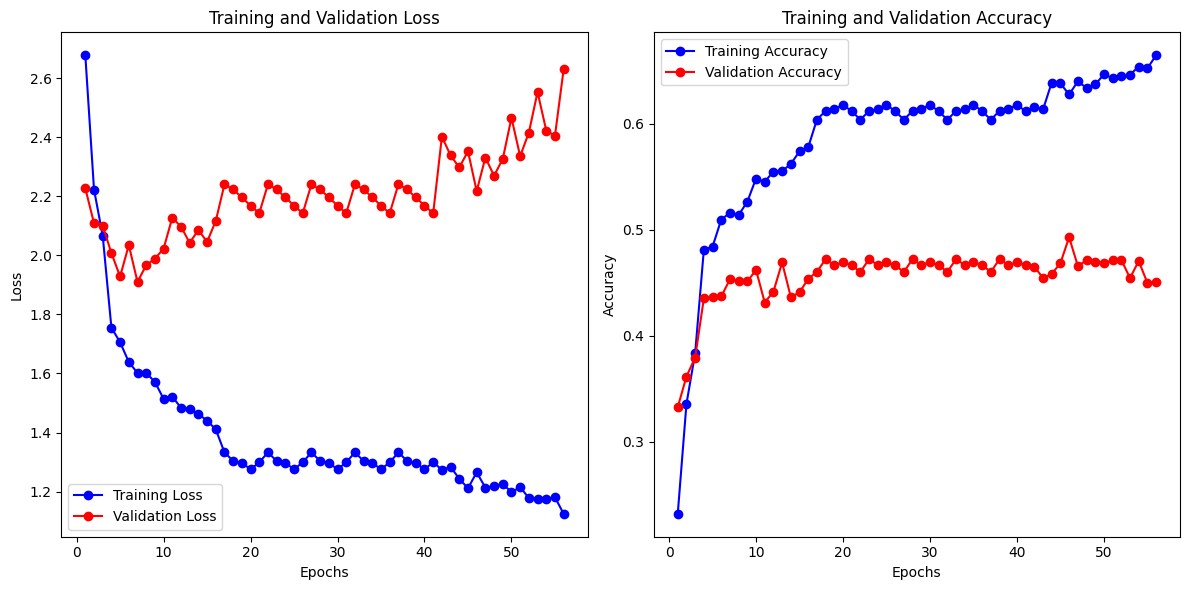

In [49]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_full_training_history(full_history):
    epochs = range(1, len(full_history['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, full_history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, full_history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, full_history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, full_history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the combined training history
plot_full_training_history(full_history)
